In [1]:
from datetime import datetime

import numpy as np
# import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    logistic_sparse_reward_function,
    linear_reward_function
)
from obp.policy import IPWLearner, Random
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    InverseProbabilityWeightingOptimalBaseline,
    SelfNormalizedInverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)
from obp.utils import estimate_confidence_interval_by_bootstrap

from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression

from tqdm.notebook import tqdm



In [2]:
'Starting'

'Starting'

In [3]:
# For different random seeds
# For different dataset sizes
# For different action spaces
# For different betas


# Generate dataset
# Generate multiple target policies
# Evaluate them
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [4]:
from collections import defaultdict

Ns = (2 ** np.arange(11, 12).astype(int))
test_N = int(1e5) #int(1e6) # Large test set for stable ground truth
As = [5, 10, 15]
betas = [1.0, 2.0, 4.0]
random_states = np.arange(1000)

ope_estimators = [InverseProbabilityWeighting(),InverseProbabilityWeightingOptimalBaseline(), SelfNormalizedInverseProbabilityWeighting()]

test_Ns = [780, 1_562, 3_125, 6_250, 12_500, 25_000, 50_000, 100_000, 200_000, 400_000, 800_000, 1_600_000]

estimator2N2statsig = defaultdict(lambda: defaultdict(list))
estimator2N2MSE = defaultdict(lambda: defaultdict(list))
estimator2N2CIwidth = defaultdict(lambda: defaultdict(list))

for A in As:
    for beta in betas:
        for test_N in test_Ns:
            for random_state in tqdm(random_states):
                dataset = SyntheticBanditDataset(
                    n_actions=A,
                    dim_context=5,
                    beta=beta, 
                    reward_type="binary", 
                    reward_function=logistic_sparse_reward_function,
                    random_state=random_state,
                )
                for N in Ns:
                    # Train
                    bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=int(N))

                    target_policies= [
                        IPWLearner(n_actions=dataset.n_actions, base_classifier=LogisticRegression(C=100, random_state=random_state)),
                        IPWLearner(n_actions=dataset.n_actions, base_classifier=RandomForest(n_estimators=30, min_samples_leaf=10, random_state=random_state))
                    ]

                    for target_policy in target_policies:
                        target_policy.fit(
                            context=bandit_feedback_train["context"],
                            action=bandit_feedback_train["action"],
                            reward=bandit_feedback_train["reward"],
                            pscore=bandit_feedback_train["pscore"]
                        )

                    # Test
                    bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=test_N)

                    target_policy_output = [
                        target_policy.predict(context=bandit_feedback_test["context"])
                        for target_policy in target_policies
                    ]

                    ope = OffPolicyEvaluation(
                        bandit_feedback=bandit_feedback_test,
                        ope_estimators=ope_estimators
                    )

                    # Delta-OPE
                    # For every unique pair of target policies
                    for i, policy_A in enumerate(target_policy_output):
                        for j, policy_B in enumerate(target_policy_output):
                            if i >= j:
                                pass
                            else:
                                # What is the true delta?
                                V_pi_A = dataset.calc_ground_truth_policy_value(
                                        expected_reward=bandit_feedback_test["expected_reward"],
                                        action_dist=policy_A,
                                )
                                V_pi_B = dataset.calc_ground_truth_policy_value(
                                        expected_reward=bandit_feedback_test["expected_reward"],
                                        action_dist=policy_B,
                                )

                                true_Delta = V_pi_A - V_pi_B
                                #print('True Delta:', true_Delta)

                                # For every conventional estimator
                                for estimator_name, estimator in ope.ope_estimators_.items():
                                    #print(estimator_name)
                                    # estimator_CI_A = estimate_confidence_interval_by_bootstrap(estimator._estimate_round_rewards(**ope._create_estimator_inputs(action_dist=policy_A)[estimator_name]),
                                    #                                                          0.05, 
                                    #                                                          1024,
                                    #                                                          random_state)
                                    # estimator_CI_B = estimate_confidence_interval_by_bootstrap(estimator._estimate_round_rewards(**ope._create_estimator_inputs(action_dist=policy_B)[estimator_name]),
                                    #                                                          0.05, 
                                    #                                                          1024,
                                    #                                                          random_state)                                
                                    Vhat_pi_A_mu = estimator.estimate_policy_value(**ope._create_estimator_inputs(action_dist=policy_A)[estimator_name])
                                    Vhat_pi_A_var = estimator.estimate_variance(**ope._create_estimator_inputs(action_dist=policy_A)[estimator_name])
                                    estimator_CI_A = {
                                        '95.0% CI (lower)': Vhat_pi_A_mu - 1.96 * np.sqrt(Vhat_pi_A_var / test_N),
                                        'mean': Vhat_pi_A_mu,
                                        '95.0% CI (upper)': Vhat_pi_A_mu + 1.96 * np.sqrt(Vhat_pi_A_var / test_N)
                                    }
                                    Vhat_pi_B_mu = estimator.estimate_policy_value(**ope._create_estimator_inputs(action_dist=policy_B)[estimator_name])
                                    Vhat_pi_B_var = estimator.estimate_variance(**ope._create_estimator_inputs(action_dist=policy_B)[estimator_name])
                                    estimator_CI_B = {
                                        '95.0% CI (lower)': Vhat_pi_B_mu - 1.96 * np.sqrt(Vhat_pi_B_var / test_N),
                                        'mean': Vhat_pi_B_mu,
                                        '95.0% CI (upper)': Vhat_pi_B_mu + 1.96 * np.sqrt(Vhat_pi_B_var / test_N)
                                    }                                
                                    estimated_Delta = estimator_CI_A['mean']-estimator_CI_B['mean']
                                    #print('\tEstimate', estimated_Delta)
                                    #print('\tSE', (true_Delta-estimated_Delta)**2)
                                    statsig = (estimator_CI_A['95.0% CI (upper)'] < estimator_CI_B['95.0% CI (lower)']) | (estimator_CI_B['95.0% CI (upper)'] < estimator_CI_A['95.0% CI (lower)'])
                                    #print('\tCIs for A:', estimator_CI_A)
                                    #print('\tCIs for B:', estimator_CI_B)
                                    #print('\tStat-sig?', statsig)

                                    estimator2N2MSE[estimator_name][test_N].append((true_Delta-estimated_Delta)**2)
                                    estimator2N2statsig[estimator_name][test_N].append(statsig)
                                    # How can we match this? Just sum widths? 
                                    #estimator2CIwidth.append()

                                # Delta-IPS
                                #print('Delta-ipw')
                                Rhat_A = ope.ope_estimators_['ipw']._estimate_round_rewards(**ope._create_estimator_inputs(action_dist=policy_A)['ipw'])
                                Rhat_B = ope.ope_estimators_['ipw']._estimate_round_rewards(**ope._create_estimator_inputs(action_dist=policy_B)['ipw'])
                                #estimator_CI_Delta = estimate_confidence_interval_by_bootstrap(Rhat_A-Rhat_B, 0.05, 1024, random_state)
                                estimator_CI_Delta = {
                                    '95.0% CI (lower)': (Rhat_A-Rhat_B).mean() - 1.96 * (Rhat_A-Rhat_B).std() / np.sqrt(Rhat_A.shape[0]),
                                    'mean': (Rhat_A-Rhat_B).mean(),
                                    '95.0% CI (upper)': (Rhat_A-Rhat_B).mean() + 1.96 * (Rhat_A-Rhat_B).std() / np.sqrt(Rhat_A.shape[0])
                                }
                                #print('\tEstimate', estimator_CI_Delta['mean'])
                                #print('\tSE', (true_Delta-estimator_CI_Delta['mean'])**2)
                                statsig = (estimator_CI_Delta['95.0% CI (lower)'] * estimator_CI_Delta['95.0% CI (upper)']) > 0.0
                                #print('\tCI for Delta:', estimator_CI_Delta)
                                #print('\tStat-sig?', statsig)
                                estimator2N2MSE['Delta-ipw'][test_N].append((true_Delta-estimator_CI_Delta['mean'])**2)
                                estimator2N2statsig['Delta-ipw'][test_N].append(statsig)
                                estimator2N2CIwidth['Delta-ipw'][test_N].append(np.abs(estimator_CI_Delta['95.0% CI (upper)'] - estimator_CI_Delta['95.0% CI (lower)']))
                                # Delta-SNIPS
                                #print('Delta-snipw')
                                SNIPS_CV_A = ope.ope_estimators_['snipw']._control_variate(**ope._create_estimator_inputs(action_dist=policy_A)[estimator_name])
                                SNIPS_CV_B = ope.ope_estimators_['snipw']._control_variate(**ope._create_estimator_inputs(action_dist=policy_B)[estimator_name])
                                g = np.asarray([
                                    1 / SNIPS_CV_A.mean(),
                                    - Rhat_A.mean() / (SNIPS_CV_A.mean()**2),
                                    - 1 / SNIPS_CV_B.mean(),
                                    Rhat_B.mean() / (SNIPS_CV_B.mean()**2),
                                ])
                                cov = np.cov(np.vstack([Rhat_A, SNIPS_CV_A, Rhat_B, SNIPS_CV_B]))                            
                                Delta_SNIPS_var = g@cov@g.T
                                # TODO: Use the above  numbers to get a closed-form CI for Delta-SNIPS
                                Rhat_A = ope.ope_estimators_['snipw']._estimate_round_rewards(**ope._create_estimator_inputs(action_dist=policy_A)['snipw'])
                                Rhat_B = ope.ope_estimators_['snipw']._estimate_round_rewards(**ope._create_estimator_inputs(action_dist=policy_B)['snipw'])
                                estimator_CI_Delta = {
                                    '95.0% CI (lower)': (Rhat_A-Rhat_B).mean() - 1.96 * np.sqrt(Delta_SNIPS_var / test_N),
                                    'mean': (Rhat_A-Rhat_B).mean(),
                                    '95.0% CI (upper)': (Rhat_A-Rhat_B).mean() + 1.96 * np.sqrt(Delta_SNIPS_var / test_N)
                                } 
                                #print(estimator_CI_Delta)
                                # estimator_CI_Delta = estimate_confidence_interval_by_bootstrap(Rhat_A-Rhat_B, 0.05, 1024, random_state)
                                #print(estimator_CI_Delta)
                                #print('\tEstimate', estimator_CI_Delta['mean'])
                                #print('\tSE', (true_Delta-estimator_CI_Delta['mean'])**2)
                                statsig = (estimator_CI_Delta['95.0% CI (lower)'] * estimator_CI_Delta['95.0% CI (upper)']) > 0.0
                                #print('\tCI for Delta:', estimator_CI_Delta)
                                #print('\tStat-sig?', statsig)
                                estimator2N2MSE['Delta-snipw'][test_N].append((true_Delta-estimator_CI_Delta['mean'])**2)
                                estimator2N2statsig['Delta-snipw'][test_N].append(statsig)
                                estimator2N2CIwidth['Delta-snipw'][test_N].append(np.abs(estimator_CI_Delta['95.0% CI (upper)'] - estimator_CI_Delta['95.0% CI (lower)']))
                                # Delta-Beta-IPS
                                #print('Delta-ipwob')
                                Rhat_A = ope.ope_estimators_['ipw']._estimate_round_rewards(**ope._create_estimator_inputs(action_dist=policy_A)['ipw'])
                                Rhat_B = ope.ope_estimators_['ipw']._estimate_round_rewards(**ope._create_estimator_inputs(action_dist=policy_B)['ipw'])
                                estim_input_A = ope._create_estimator_inputs(action_dist=policy_A)['ipw']
                                estim_input_B = ope._create_estimator_inputs(action_dist=policy_B)['ipw']

                                prob_A = estim_input_A['action_dist'][np.arange(estim_input_A['action'].shape[0]), estim_input_A['action'], estim_input_A['position']].ravel()
                                prob_B = estim_input_B['action_dist'][np.arange(estim_input_B['action'].shape[0]), estim_input_B['action'], estim_input_B['position']].ravel()
                                Delta_iw = (prob_A - prob_B) / estim_input_A['pscore']                            
                                # optimal_baseline_Delta_IPW = (np.mean(estim_input_A['reward'] * (Delta_iw**2 - Delta_iw)))/(np.clip(np.mean(Delta_iw**2 - Delta_iw), a_min=1e-11, a_max=np.Inf))
                                optimal_baseline_Delta_IPW = (np.mean(estim_input_A['reward'] * (Delta_iw**2)))/(np.clip(np.mean(Delta_iw**2), a_min=1e-11, a_max=np.Inf))
                                
                                #print('Beta', optimal_baseline_Delta_IPW)
                                diff_estimate = (estim_input_A['reward'] - optimal_baseline_Delta_IPW) * Delta_iw
                                #estimator_CI_Delta = estimate_confidence_interval_by_bootstrap(diff_estimate, 0.05, 1024, random_state)
                                estimator_CI_Delta = {
                                    '95.0% CI (lower)': diff_estimate.mean() - 1.96 * np.sqrt(diff_estimate.var() / test_N),
                                    'mean': diff_estimate.mean(),
                                    '95.0% CI (upper)': diff_estimate.mean() + 1.96 * np.sqrt(diff_estimate.var() / test_N)
                                } 
                                #print('\tEstimate', estimator_CI_Delta['mean'])
                                #print('\tSE', (true_Delta-estimator_CI_Delta['mean'])**2)
                                statsig = (estimator_CI_Delta['95.0% CI (lower)'] * estimator_CI_Delta['95.0% CI (upper)']) > 0.0
                                #print('\tCI for Delta:', estimator_CI_Delta)
                                #print('\tStat-sig?', statsig)

                                estimator2N2MSE['Delta-ipwob'][test_N].append((true_Delta-estimator_CI_Delta['mean'])**2)
                                estimator2N2statsig['Delta-ipwob'][test_N].append(statsig)
                                estimator2N2CIwidth['Delta-ipwob'][test_N].append(np.abs(estimator_CI_Delta['95.0% CI (upper)'] - estimator_CI_Delta['95.0% CI (lower)']))
                        #print('---------')
                

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
for e, N2v in estimator2N2MSE.items():
    print(e)
    for N, v in N2v.items():
        print('\t', N, np.mean(v), np.std(v)/np.sqrt(len(v)))

ipw
	 780 0.009393274825509416 0.0001761851147769303
	 1562 0.004611161921451776 8.361886182242694e-05
	 3125 0.0022239628764722523 4.02795727697825e-05
	 6250 0.0011186750467818652 2.075995507049332e-05
	 12500 0.0005509457675820733 1.0097415886858987e-05
	 25000 0.00027790378577866753 5.041597120608391e-06
	 50000 0.00013992759699192877 2.5572062782249135e-06
	 100000 7.051860080790487e-05 1.2597268553129421e-06
	 200000 3.4568971280866985e-05 6.079894989363046e-07
	 400000 1.7090005745198663e-05 3.0523803722815984e-07
	 800000 8.664548134738149e-06 1.5278117515711775e-07
	 1600000 4.270848959942023e-06 7.699070928931455e-08
ipwob
	 780 0.004439120318326521 8.092978128214381e-05
	 1562 0.00218751606019216 3.981317979301903e-05
	 3125 0.0010890434392210266 2.0818251197548235e-05
	 6250 0.0005413636839921333 9.698331885789089e-06
	 12500 0.0002730634840360642 5.2328046545963165e-06
	 25000 0.0001388486458905428 2.605374642600407e-06
	 50000 6.823061369899825e-05 1.278233601885686e-06
	

In [6]:
for e, N2v in estimator2N2CIwidth.items():
    print(e)
    for N, v in N2v.items():
        print('\t', N, np.mean(v), np.std(v)/np.sqrt(len(v)))

Delta-ipw
	 780 0.3537012100703851 0.0011879366617598755
	 1562 0.25039374110321794 0.0008095258842955875
	 3125 0.1769379163527539 0.0005639877658049552
	 6250 0.12506316701947195 0.00039520138837246074
	 12500 0.08840636596827749 0.0002760053119848569
	 25000 0.06249712997567642 0.00019472926709086848
	 50000 0.04418624319356557 0.00013721351070189957
	 100000 0.031247519221900902 9.689875102674625e-05
	 200000 0.02209729843996682 6.848873384419286e-05
	 400000 0.015624988274925793 4.840097388222008e-05
	 800000 0.011047303906813098 3.4210397564137616e-05
	 1600000 0.007811554159839769 2.4186823212302767e-05
Delta-snipw
	 780 0.2564441250981702 0.0010769867810355327
	 1562 0.18691627455852858 0.0008055806378392637
	 3125 0.13546996045426002 0.0005983877658276617
	 6250 0.0976975543342543 0.00043424967151978297
	 12500 0.06989908782785072 0.00031192998312014694
	 25000 0.049719695528347464 0.00021969772958487776
	 50000 0.0353584547945521 0.00015611505729773873
	 100000 0.025036309143

In [7]:
for e, N2v in estimator2N2statsig.items():
    print(e)
    for N, v in N2v.items():
        print('\t', N, np.mean(v), np.std(v)/np.sqrt(len(v)))

ipw
	 780 0.009444444444444445 0.001019544937355237
	 1562 0.019555555555555555 0.0014595713146319952
	 3125 0.04644444444444444 0.0022182915854997605
	 6250 0.10266666666666667 0.0031994135265045447
	 12500 0.18911111111111112 0.004127793313697231
	 25000 0.3045555555555556 0.004851133534612783
	 50000 0.4232222222222222 0.00520795516322552
	 100000 0.5415555555555556 0.005252228477327708
	 200000 0.6383333333333333 0.005064735255655181
	 400000 0.7231111111111111 0.00471665408830791
	 800000 0.7868888888888889 0.004316567121530447
	 1600000 0.8347777777777777 0.0039146993570696375
ipwob
	 780 0.023777777777777776 0.0016059747840046277
	 1562 0.04655555555555556 0.0022208140600156593
	 3125 0.0908888888888889 0.0030299999773639916
	 6250 0.17888888888888888 0.004039907236572363
	 12500 0.2922222222222222 0.004793843216526432
	 25000 0.41733333333333333 0.005197929312312979
	 50000 0.5392222222222223 0.005254221765864418
	 100000 0.6396666666666667 0.005060667744941507
	 200000 0.72755

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': True,
    'svg.fonttype': 'none',
    'font.family': 'Linux Libertine',
    'text.latex.preamble': r'\usepackage{libertine}',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'libertine',
    'mathtext.it': 'libertine:italic',
    'mathtext.bf': 'libertine:bold'
    }
mpl.rcParams.update(new_rc_params)
plt.style.use('tableau-colorblind10')
plt.rc('axes', axisbelow=True)

In [9]:
# Taken from
# https://gist.github.com/AndiH/c957b4d769e628f506bd

# Tableau 20 Colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

In [10]:
estimator2colour = {
    'ipw': tableau20[0],
    'ipwob': tableau20[4],
    'snipw': tableau20[2],
    'Delta-ipw': tableau20[1],
    'Delta-snipw': tableau20[3],
    'Delta-ipwob': tableau20[5]
}
estimator2label = {
    'ipw': r'$\widehat{V}_{\rm IPS}$',
    'ipwob': r'$\widehat{V}_{{\beta}{\rm -IPS}}$',
    'snipw': r'$\widehat{V}_{\rm SNIPS}$',
    'Delta-ipw': r'$\widehat{V}_{{\Delta}{\rm -IPS}}$',
    'Delta-snipw': r'$\widehat{V}_{{\Delta}{\rm -SNIPS}}$',
    'Delta-ipwob': r'$\widehat{V}_{{\Delta\beta}{\rm -IPS}}$'
}
estimator2marker = {
    'ipw': 's',
    'Delta-ipw': 'D',
    'snipw': 'v',
    'Delta-snipw': '^',
    'ipwob': 'x',
    'Delta-ipwob': '+'
}

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) 

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) 

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) 

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) 

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) 

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) 

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) 

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) 

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) 

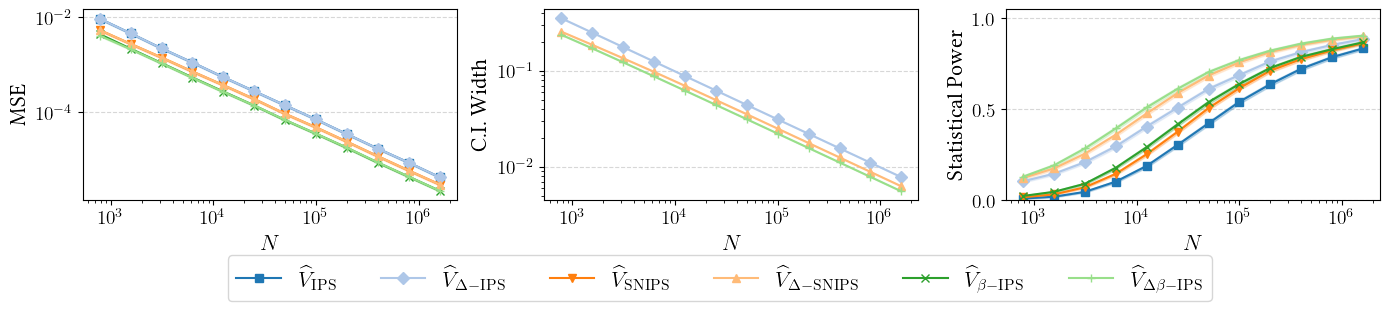

In [11]:

fig, axes = plt.subplots(1, 3, figsize=(14, 2.75))
fontsize=18

for e, N2v in estimator2N2MSE.items():
    if e in [12500]:
        continue
    x = np.asarray(list(N2v.keys()))
    x = np.sort(x)
    y = np.asarray([np.mean(N2v[N]) for N in x])
    y_err = np.asarray([np.std(N2v[N])/np.sqrt(len(N2v[N])) for N in x])    
    axes[0].plot(x,y,label=estimator2label[e], color=estimator2colour[e], marker=estimator2marker[e])
    axes[0].fill_between(x,y-1.96*y_err, y+1.96*y_err, alpha=.25, color=estimator2colour[e])

    #print('\t', N, np.mean(v), np.std(v)/np.sqrt(len(v)))

for e, N2v in estimator2N2CIwidth.items():
    x = np.asarray(list(N2v.keys()))
    x = np.sort(x)
    y = np.asarray([np.mean(N2v[N]) for N in x])
    y_err = np.asarray([np.std(N2v[N])/np.sqrt(len(N2v[N])) for N in x])
    axes[1].plot(x,y,label=estimator2label[e], color=estimator2colour[e], marker=estimator2marker[e])
    axes[1].fill_between(x,y-1.96*y_err, y+1.96*y_err, alpha=.25, color=estimator2colour[e])
    #print('\t', N, np.mean(v), np.std(v)/np.sqrt(len(v)))

# for e, N2v in estimator2N2statsig.items():
for e in ['ipw', 'Delta-ipw', 'snipw', 'Delta-snipw', 'ipwob', 'Delta-ipwob']:
    N2v = estimator2N2statsig[e]
    x = np.asarray(list(N2v.keys()))
    x = np.sort(x)
    y = np.asarray([np.mean(N2v[N]) for N in x])
    y_err = np.asarray([np.std(N2v[N])/np.sqrt(len(N2v[N])) for N in x])
    axes[2].plot(x,y,label=estimator2label[e], color=estimator2colour[e], marker=estimator2marker[e])
    axes[2].fill_between(x,y-1.96*y_err, y+1.96*y_err, alpha=.25, color=estimator2colour[e])
    #print('\t', N, np.mean(v), np.std(v)/np.sqrt(len(v)))

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[2].set_xscale('log')
axes[2].set_ylim(0.0, 1.05)

axes[0].set_xlabel(r'$N$', fontsize=fontsize-2)
axes[1].set_xlabel(r'$N$', fontsize=fontsize-2)
axes[2].set_xlabel(r'$N$', fontsize=fontsize-2)
axes[0].set_ylabel(r'MSE', fontsize=fontsize-2)
axes[1].set_ylabel(r'C.I. Width', fontsize=fontsize-2)
axes[2].set_ylabel(r'Statistical Power', fontsize=fontsize-2)

axes[0].grid(axis='y', ls='--', alpha=.5)
axes[1].grid(axis='y', ls='--', alpha=.5)
axes[2].grid(axis='y', ls='--', alpha=.5)

for ax in axes:
    ax.xaxis.set_tick_params(labelsize=fontsize-4)            
    ax.yaxis.set_tick_params(labelsize=fontsize-4)

fig.tight_layout()
axes[2].legend(fontsize=fontsize-2, ncol=6, loc='upper right', bbox_to_anchor=(0.58,-.23))

plt.savefig('DeltaBetaIPS_OBPExperiment.pdf', bbox_inches='tight')
plt.show()

In [12]:
'test'

'test'

In [13]:
'tst'

'tst'